<font size = 6><b>CSE 255 Take Home Final: Analysis of stock prices</b></font>


In this take-home final you are to analyze the daily changes in stock prices using PCA and to measure the intrinsic dimension of stock sequences. Later you will also use xgboost to predict stock category from the eigenvectors of the data.

## Notebook 1: Preparing Data

In [1]:
!pwd  

## should be /home/jovyan/work/Final if you're using docker. If you're not using docker,
## you should still work inside the `Final` folder before proceeding forward.

/home/fanjin/Works/CSE255-DSE230-2018/Final


In [2]:
## importing some useful python libraries

import sys,os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob
import pickle


### Download Data

We start by downloading data and pre-processing it to make it ready for analysis using Spark.

The data is a directory with .csv files, one for each stock. This directory has been tarred and uploaded to S3, at: https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz

Download and untar the file to create a subdirectory of the current directory called `spdata_csv`

In [3]:
!pwd  

## should be /home/jovyan/work/Final if you're using docker. If you're not using docker,
## you should still work inside the `Final` folder before proceeding forward.

/home/fanjin/Works/CSE255-DSE230-2018/Final


In [4]:
## creating the necessary directory structure and downloading/extracting data 

%mkdir -p data/
%cd data
!rm -f spdata_csv.tgz && rm -rf spdata_csv ## Deleting any old copy present
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz ## Downloading data
!tar -xf spdata_csv.tgz ## Extracting data
## Going back to `Final` directory to keep it as our working directory
%cd ../ 
%ls -al data/

/home/fanjin/Works/CSE255-DSE230-2018/Final/data
--2018-06-14 05:55:17--  https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.248.202
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.248.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108227395 (103M) [application/x-tar]
Saving to: ‘spdata_csv.tgz’

spdata_csv.tgz      100%[===================>] 103.21M  32.8MB/s    in 3.7s    

2018-06-14 05:55:21 (27.6 MB/s) - ‘spdata_csv.tgz’ saved [108227395/108227395]

/home/fanjin/Works/CSE255-DSE230-2018/Final
total 240928
drwxrwxr-x 4 fanjin fanjin      4096 Jun 14 05:55 ./
drwxrwxr-x 6 fanjin fanjin      4096 Jun 14 05:55 ../
drwxr-xr-x 2 fanjin fanjin      4096 Jun  8 13:17 data/
-rw-rw-r-- 1 fanjin fanjin  52006823 Jun  8 17:12 data.tgz
-rw-rw-r-- 1 fanjin fanjin   1864236 Jun  9 20:06 PCA.pickle
-rw-rw-r-- 1 fanjin fanjin  84562573 Jun 14 

In [5]:
## How is the data structured?

files=!ls -1 data/spdata_csv/train/
files[:5]

['AAPL.csv', 'ABC.csv', 'ABT.csv', 'ACN.csv', 'A.csv']

In [6]:
## How many train and test stocks?

!ls -l data/spdata_csv/train/ | wc
!ls -l data/spdata_csv/test/ | wc

    393    3530   21978
     90     803    4897


## Read Data and create a single table

Your task in this notebook is to read the stock-information `.csv` files, extract from them the column 
`Adj. Open` and combine them into a single `.csv` file containing all of the information that is relevant for later analysis.

Below we suggest a particular sequence of steps, you can either follow these steps, or do this in your own way.  The end result should be a file called `SP500.csv` which stores the information described below.

### Step 1: files into pandas dataframes

In this step we read all of the relevant information into a large dictionary we call `Tables`.

The key to this dictionary is the stocks "ticker" which corresponds to the file name excluding the `.csv` extension. Hence, we read in all of the files in the directory `spdata_csv`.

In [7]:
cur_dir = !pwd
print("The current working directory: ", cur_dir)
data_dir_rel_path = 'data/spdata_csv/'

The current working directory:  ['/home/fanjin/Works/CSE255-DSE230-2018/Final']


In [8]:
%cd $data_dir_rel_path
Tables={}
for filename in glob('*/*.csv'):
    print('\r',filename, end=' ')
    head, tail = os.path.split(filename)
    #stock_name = tail[:-4]
    code = filename[:-4]
    tbl=pd.read_csv(filename,index_col='Date',parse_dates=True)
    if(np.shape(tbl)[1]==12):
        Tables[code]=tbl.sort_index()
        Tables[code]
    else:
        print("This file does not have the correct number of columns.")
        print(filename,np.shape(tbl))
        
%cd ../../
print("The current working directory: ", cur_dir)

/home/fanjin/Works/CSE255-DSE230-2018/Final/data/spdata_csv
 test/39.csv /home/fanjin/Works/CSE255-DSE230-2018/Final
The current working directory:  ['/home/fanjin/Works/CSE255-DSE230-2018/Final']


In [9]:
# Example of an entry in `Tables`
print(len(Tables))
Tables['train/IBM'].head()

481


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1962-01-02,578.5,578.5,572.0,572.00,5162.666667,0.0,1.0,5.180989,5.180989,5.122776,5.122776,387200.0
1962-01-03,572.0,577.0,572.0,577.00,3840.000000,0.0,1.0,5.122776,5.167555,5.122776,5.167555,288000.0
1962-01-04,577.0,577.0,571.0,571.25,3413.333333,0.0,1.0,5.167555,5.167555,5.113820,5.116059,256000.0
1962-01-05,570.5,570.5,559.0,560.00,4842.666667,0.0,1.0,5.109342,5.109342,5.006349,5.015305,363200.0
1962-01-08,559.5,559.5,545.0,549.50,7253.333333,0.0,1.0,5.010827,5.010827,4.880966,4.921268,544000.0


### Step 2: Computing diffs and combining into a single table

The next step is to extract the relevant prices from each table, compute an additional quantity we call `diff` and create a single combined pandas dataframe called `Diffs` containing info about all stocks.

The price we will use is the **Adjusted Open Price** which is the price when the stock exchange opens in the morning. We use the **adjusted** price which eliminates technical adjustments such as stock splits.

It is more meaningful to predict *changes* in prices than prices themselves. We therefore compute, for each stock, a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at day $t$ and $d(t)$ is the price diff or the price ratio.

Obviously, if we have a price sequence of length $T$ then the length of the diff sequence will be $T-1$. To make the price sequence and the diff sequence have the same length we eliminate the last day price for each sequence after we've calculated the `diff` for that stock.

Your task in this step is to compute the diff sequence for each stock, and `join` them by date,  and create one large Pandas DataFrame called `Diffs` where the row index is the date, and there are two columns for each ticker. For example for the ticker `IBM`, there would be two columns `IBM_P` and `IBM_D`. The first corresponds to the prices of the IBM stock $p(t)$ and the second to the price difference $d(t)$. In total, the resultant Pandas dataframe should have 962 columns (i.e. 481*2).

In [10]:
def construct_df_with_diffs_and_prices(Tables):
    ## This is the df you will use to store the required info.
    ## You may keep `joining` calculated data for each stock in this DF.
    Diffs=pd.DataFrame()
    
    Indices=set(Tables.keys())
    print(len(Indices))
    
    for code in Indices:
        
        Diffs[code+'_P'] = Tables[code]['Open']
        Diffs[code+'_D'] = np.log(Tables[code]['Close']) -  np.log(Tables[code]['Open'])
    
    return Diffs

In [11]:
Diffs = construct_df_with_diffs_and_prices(Tables)
Diffs.head()

481


,train/HST_P,train/HST_D,train/VFC_P,train/VFC_D,train/PBCT_P,train/PBCT_D,train/TEL_P,train/TEL_D,train/VMC_P,train/VMC_D,...,test/3_P,test/3_D,test/86_P,test/86_D,train/EXPE_P,train/EXPE_D,train/BA_P,train/BA_D,test/88_P,test/88_D
Date,,,,,,,,,,,,,,,,,,,,,
1983-04-06,62.37,-0.016163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.12,0.000000,NaN,NaN
1983-04-07,61.37,-0.033132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.12,0.000000,NaN,NaN
1983-04-08,59.00,0.010621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.12,0.015581,NaN,NaN
1983-04-11,59.88,0.022621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.00,0.024098,NaN,NaN
1983-04-12,61.50,0.002112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.00,-0.003100,NaN,NaN


In [12]:
assert True if 'train/IBM_P' in Diffs else False, "Please check your implementation."
assert True if 'train/IBM_D' in Diffs else False, "Please check your implementation."

In [13]:
assert len(Diffs['train/IBM_P'])==len(Diffs['train/IBM_D'])==Diffs.shape[0], "The number of rows across stocks should remain fixed."
assert len(Diffs.columns) == 962, "The number of columns are not correct. Please check your implementation"

In [14]:
assert type(Diffs['train/IBM_P']) == pd.Series, "Every column should be a pandas series"
assert type(Diffs['train/IBM_P'][0]) == np.float64, "Every data point in a series should be np.float64"
assert type(Diffs['train/IBM_D']) == pd.Series, "Every column should be a pandas series"
assert type(Diffs['train/IBM_D'][0]) == np.float64, "Every data point in a series should be np.float64"

In [15]:
#Hidden tests here

In [16]:
#Hidden tests here

In [17]:
#Hidden tests here

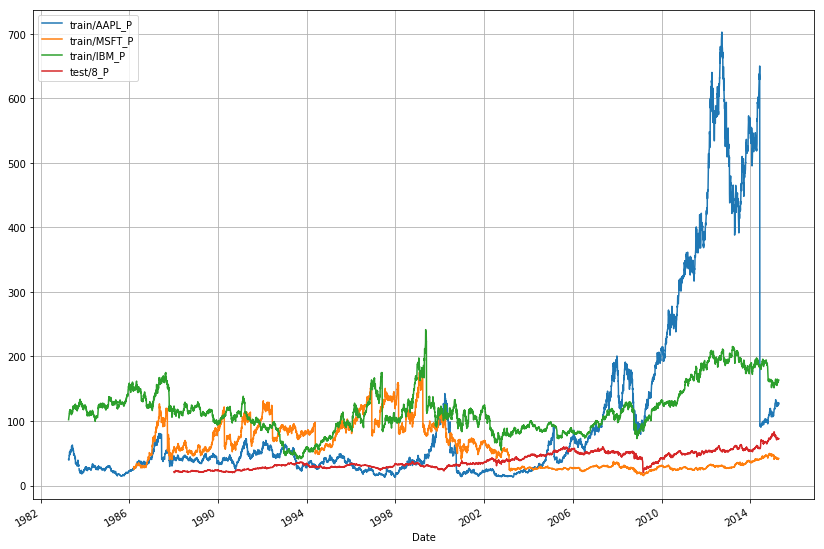

In [18]:
# plot some stocks

Diffs[['train/AAPL_P','train/MSFT_P','train/IBM_P','test/8_P']].plot(figsize=(14,10));
plt.grid()

### Black Monday

One of the biggest crashes in the US stock market happened on
**Black Monday:** Oct 19 1987  

We will look at the stocks around that date

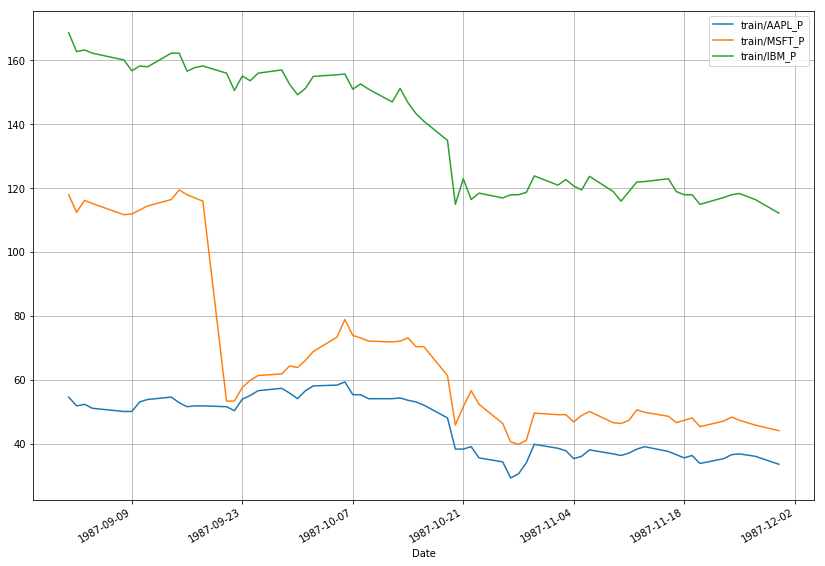

In [19]:
#Focus on "Black Monday:" the stock crash of Oct 19 1987

import datetime
format = "%b-%d-%Y"

_from = datetime.datetime.strptime('Sep-1-1987', format)
_to = datetime.datetime.strptime('Nov-30-1987', format)

Diffs.loc[_from:_to,['train/AAPL_P','train/MSFT_P','train/IBM_P']].plot(figsize=(14,10));
plt.grid()

**Why does it seems that the price of IBM fell much more than those of Apple and microsoft?**

Because IBM's price started so much higher. As explained above it is more informative to consider $\log(p_{t+1}/p_t)$

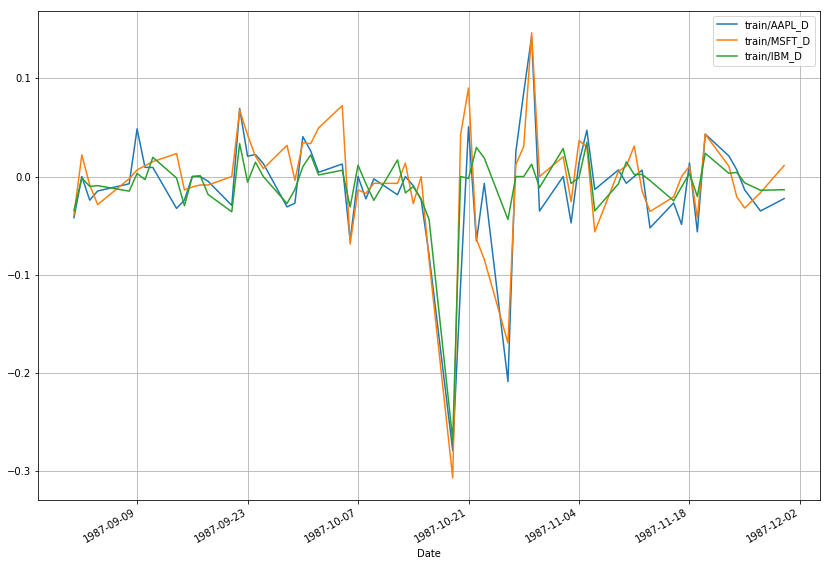

In [20]:
Diffs.loc[_from:_to,['train/AAPL_D','train/MSFT_D','train/IBM_D']].plot(figsize=(14,10));
plt.grid()

### Extract column names in lexicographical order

Complete the following function to extract the column names from a Pandas dataframe lexicographically, treating train and test tickers separately. The train tickers should be present before the test tickers in the returned list. Consider the Input and example output below.

Input: `Diffs` dataframe calculated in 2.2

Returns: `dataset/ticker_category` - list of tickers

Example Output:

   ```
  [
  'train/AAPL_D',
  'train/AAPL_P',
  'train/ABC_D',
  'train/ABC_P',
  'train/ABT_D',
  .
  .
  .
  'train/YUM_P',
  'train/ZION_D',
  'train/ZION_P',
  'test/0_D', 
  'test/0_P', 
  'test/10_D'
  .
  .
  .
  'test/8_P', 
  'test/9_D', 
  'test/9_P'
  ]```

In [21]:
def partition_columns(df):
    """Partition columns of df into train set and test set
    Each of them sorted lexicographically."""
    
    train_col=[]
    test_col=[]
    
    Indices=set(df.keys())
    
    for code in Indices:
        if code.startswith('train'):
            train_col.append(code)
        elif code.startswith('test'):
            test_col.append(code)
            
    train_col.sort()
    test_col.sort()
    
    return  train_col+test_col

columns = partition_columns(Diffs)

In [22]:
## Are they sorted as expected?
columns[:5],columns[-5:]

(['train/AAPL_D', 'train/AAPL_P', 'train/ABC_D', 'train/ABC_P', 'train/ABT_D'],
 ['test/88_P', 'test/8_D', 'test/8_P', 'test/9_D', 'test/9_P'])

In [23]:
assert type(columns) == list, 'Incorrect return type'
assert len(columns) == 962, 'Incorrect return value'

In [24]:
#Hidden tests here

In [25]:
Diffs=Diffs[columns]

## Are the columns of the Diffs dataframe sorted now?
Diffs.columns

Index(['train/AAPL_D', 'train/AAPL_P', 'train/ABC_D', 'train/ABC_P',
       'train/ABT_D', 'train/ABT_P', 'train/ACN_D', 'train/ACN_P',
       'train/ADBE_D', 'train/ADBE_P',
       ...
       'test/86_D', 'test/86_P', 'test/87_D', 'test/87_P', 'test/88_D',
       'test/88_P', 'test/8_D', 'test/8_P', 'test/9_D', 'test/9_P'],
      dtype='object', length=962)

In [26]:
!pwd  

## should be /home/jovyan/work/Final if you're using docker. If you're not using docker,
## you should still work inside the `Final` folder before proceeding forward.

/home/fanjin/Works/CSE255-DSE230-2018/Final


In [27]:
## Saving the data to appropriate location for use in next notebooks
!rm -rf data/SP500.csv
Diffs.to_csv('data/SP500.csv')

### Note

In order to make sure errors in constructing data do not get propagated in other notebooks of the final, you may run the below cell which will download the instructors version of "SP500.csv". For next notebooks, you may use either your own version or the one provided by us. Ideally both should have the same contents

In [28]:
%mkdir -p data/
%cd data
!rm -f data.tgz && rm -rf data ## Instructor's version of the output from this notebook
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
!tar -xf data.tgz ## Extracting data
%cd ../ 
## Going back to `Final` directory to keep it as our working directory
%ls -al data/

## Now the `data` folder should have another `data` folder which contains the instructors version of SP500.csv

/home/fanjin/Works/CSE255-DSE230-2018/Final/data
--2018-06-14 05:57:43--  https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.204.114
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.204.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52006823 (50M) [application/x-tar]
Saving to: ‘data.tgz’

data.tgz            100%[===================>]  49.60M  21.6MB/s    in 2.3s    

2018-06-14 05:57:45 (21.6 MB/s) - ‘data.tgz’ saved [52006823/52006823]

/home/fanjin/Works/CSE255-DSE230-2018/Final
total 235328
drwxrwxr-x 4 fanjin fanjin      4096 Jun 14 05:57 ./
drwxrwxr-x 6 fanjin fanjin      4096 Jun 14 05:57 ../
drwxr-xr-x 2 fanjin fanjin      4096 Jun  8 13:17 data/
-rw-rw-r-- 1 fanjin fanjin  52006823 Jun  8 17:12 data.tgz
-rw-rw-r-- 1 fanjin fanjin   1864236 Jun  9 20:06 PCA.pickle
-rw-rw-r-- 1 fanjin fanjin  78829435 Jun 14 05:57 SP500.csv
drwxr-

In [ ]:
## How different is your version than the instructors?
!diff data/SP500.csv data/data/SP500.csv

2,10573c2,13423
< 1973-05-03,,,,,,,,,,,,,,,,,,,,,0.009478743954543845,26.25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,56.38,,,,,,,,,0.0583803067336337,18.63,,,,,,,,,,,,,,,,,0.0074349784875180625,33.5,,,,,0.0056866363956453725,64.88,,,,,,,,,,,-0.010274900800840037,61.63,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.0059701669865037665,42.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.014771317320312782,84.0,,,0.018854800763629775,170.75,0.09514645051863724,38.87,,,,,,,,,,,,,0.04336722911512947,90.25,,,,,0.009456335242035152,105.25,,,,,0.0062847680878936885,20.62,,,,,,,,,,,,,,,-0.01072175219414051,24.38,,,,,,,,,-0.002953848301592288,81.37,,,,,,,,,,,-0.0073260400920727164,34.25,0.010666767804195398,22.38,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0336860576548057,61.88,,,0.006173374073153326,59.75,,,,,,,,,,,,,,,0.019231361927887658,25.75,,,0.011849082768574881,136.75,,,,,,,,,,,,,,,-0.011408109313961745,33.5,0.011216516743683513,77.13,,,,,,,,,,,,,,,0.02056376594532683,415.37,,,,,,,,,,,0.0178114447296

< 1974-04-08,,,,,,,,,,,,,,,,,,,,,0.0,24.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.006006024060212223,41.75,,,,,,,,,-0.009164674649563498,14.25,,,,,,,,,,,,,,,,,0.0,32.13,,,,,0.0,47.38,,,,,,,,,,,-0.009132483563272675,55.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.005238778856279325,24.88,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.02199450138228176,28.5,,,-0.002198260101579308,168.5,-0.016231194928582493,39.13,,,,,,,,,,,,,-0.007639141102982361,48.62,,,,,-0.014455680818036498,60.62,,,,,-0.007083854888405128,17.0,,,,,,,,,,,,,,,-0.04773140282118993,18.88,,,,,,,,,-0.009396706135063049,40.63,,,,,,,,,,,0.0,29.38,-0.016807118316381153,15.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0024395214375405594,49.13,,,-0.004597709248629567,54.5,,,,,,,,,,,,,,,-0.0077914688437732416,16.75,,,-0.00348432408261079,143.75,,,,,,,,,,,,,,,-0.018403169357641413,41.13,-0.005934735519814716,84.5,,,,,,,,,,,,,,,-0.01184720372599024,233.5,,,,,,,,,,,-0.002583723985279285,50.38,,,,,,,,,,,,,,,-0.009195467093100262,109.25,,,

< 1975-02-12,,,,,,,,,,,,,,,,,,,,,0.02048231028313241,17.88,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,32.88,,,,,,,,,-0.0077312308967356635,16.88,,,,,,,,,,,,,,,,,0.008263144025416835,30.13,,,,,0.017241806434506124,57.5,,,,,,,,,,,0.0,58.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.005288685751513533,22.75,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.02511270081507533,24.38,,,0.024355106100318658,96.13,0.03736222330466221,36.25,,,,,,,,,,,,,0.03677425698478043,33.37,,,,,0.009890015211875713,62.38,,,,,0.0,12.12,,,,,,,,,,,,,,,0.0,10.75,,,,,,,,,0.003974831334640605,30.13,,,,,,,,,,,0.03338119261619665,25.63,0.0,14.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.04255961441879563,34.5,,,0.03391821820346097,40.0,,,,,,,,,,,,,,,0.007772059847702906,15.38,,,0.006477333445981337,133.88,,,,,,,,,,,,,,,0.01761909744059098,34.88,0.024008304196026842,77.37,,,,,,,,,,,,,,,0.041912561227261946,201.62,,,,,,,,,,,0.00623378642081418,38.38,,,,,,,,,,,,,,,0.022858138076049528,86.5,,,,,,,,,,,,,,,,,,,0.057646984779696986,71.6

< 1975-11-25,,,,,,,,,,,,,,,,,,,,,0.0,21.25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,38.38,,,,,,,,,0.0,24.25,,,,,,,,,,,,,,,,,-0.009132483563272675,27.5,,,,,0.013538668332798487,72.63,,,,,,,,,,,0.0072993024816119245,68.25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,22.88,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.008733679968754515,28.5,,,0.010672129748865444,128.62,0.0026228200247047084,49.5,,,,,,,,,,,,,0.004819286435949088,51.75,,,,,0.00415573651452128,91.25,,,,,-0.009164674649563498,14.25,,,,,,,,,,,,,,,0.009763502267851276,13.25,,,,,,,,,0.0,38.0,,,,,,,,,,,0.021676403502371766,28.75,0.008241804895103844,14.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.005883062032003394,42.37,,,0.010337077781499282,48.12,,,,,,,,,,,,,,,0.028723196401187145,21.62,,,0.012739025777429802,136.5,,,,,,,,,,,,,,,0.0183382837924575,33.5,0.011766077540614539,94.63,,,,,,,,,,,,,,,0.010607211140876593,222.25,,,,,,,,,,,0.02066453709527538,54.12,,,,,,,,,,,,,,,0.0026702285558783956,93.5,,,,,,,,,,,,,,,,,,,0.007205383721270664

< 1976-08-06,,,,,,,,,,,,,,,,,,,,,0.011173300598124936,22.25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,39.25,,,,,,,,,0.0,42.0,,,,,,,,,,,,,,,,,0.0,32.13,,,,,-0.004738754347173746,80.38,,,,,,,,,,,-0.0060720626376076225,61.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0045180799747890354,26.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.013158084577511442,37.75,,,-0.0027218908186608104,136.12,-0.003773304605257266,66.38,,,,,,,,,,,,,-0.019705071079332726,51.25,,,,,0.011299555253933669,44.0,,,,,0.018246120227804585,14.12,,,,,,,,,,,,,,,0.01360565205577835,18.25,,,,,,,,,0.0,37.25,,,,,,,,,,,0.005883062032003394,42.37,0.007968169649176904,15.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.004404905369272072,56.88,,,-0.002360847369121011,55.13,,,,,,,,,,,,,,,0.005825694271529791,22.25,,,-0.002086175834840276,62.38,,,,,,,,,,,,,,,0.0,40.25,-0.015364490411570841,106.25,,,,,,,,,,,,,,,0.002291451709183434,274.62,,,,,,,,,,,-0.0055726790350485444,68.38,,,,,,,,,,,,,,,0.0,86.88,,,,,,,,,,,,,,,,,,,-0.008608374536600572

< 1977-04-11,,,,,,,,,,,,,,,,,,,,,0.010000083334583465,23.88,,,0.02597548640326064,28.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.013737589781363635,36.87,,,,,,,,,0.014829260029122437,41.5,,,,,,,,,,,,,,,,,0.013650225598416554,36.38,,,,,0.010029535637178455,62.5,,,,,,,,,,,0.007012392640050269,54.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.01483885258529849,24.75,,,,,,,,,,,,,0.0,32.38,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.003275799829935977,39.62,-0.003014320292922701,39.87,0.02193507686625562,124.0,0.0039100734078427735,30.63,,,,,,,,,,,,,-0.0037212008018538967,35.0,,,,,0.0067796869853786745,36.75,,,,,0.01600034134644135,15.5,,,,,,,,,,,,,,,0.0,22.25,,,,,,,,,0.011279430952833014,33.5,,,,,,,,,,,0.0059347355198142715,42.0,0.007528266420791407,15.88,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.011441149046206078,54.75,0.0,54.25,0.0026361162989356757,49.25,,,,,,,,,,,,,,,-0.006134988567516153,19.62,,,0.01106536275059522,56.62,,,,,,,,,,,,,,,0.003010306777146976,43.12,0.0,72.5,,,,,,,,,,,,,,,-0.0004698483921847796,276.7

< 1977-11-11,,,,,,,,,,,,,,,,,,,,,0.010256500167189486,24.25,,,0.023794367484675227,36.13,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.006514681021193791,38.25,,,,,,,,,0.03551942896045723,27.38,,,,,,,,,,,,,,,,,0.01625533800736667,31.12,,,,,0.007168489478612372,34.75,,,,,,,,,,,0.014051753455650129,53.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.01578867873585077,23.25,,,,,,,,,,,,,0.011362013831771822,32.38,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.009545412843531498,39.62,0.019740080385977077,37.62,0.010537505302785632,118.0,0.01384861782607194,27.25,,,,,,,,,,,,,0.009689744532475508,38.0,,,,,0.0,29.0,,,,,0.0,16.75,,,,,,,,,,,,,,,0.010362787035546273,24.0,,,,,,,,,0.01459879942115272,34.0,,,,,,,,,,,0.013158084577511442,37.75,0.0,17.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.008386718767101176,45.12,0.009852296443011443,50.5,0.004784240299551268,52.13,,,,,,,,,,,,,,,0.006644542718668767,18.0,,,0.003809528416668151,62.88,,,,,,,,,,,,,,,0.01146013000830104,43.38,0.004945542393014257,74.63,,,,,,,,,,,,,,,0.00238636039500850

< 1978-04-10,,,,,,,,,,,,,,,,,,,,,0.0,23.38,,,0.0,35.75,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,32.62,,,,,,,,,0.0,34.88,,,,,,,,,,,,,,,,,0.0078049176693841815,30.63,,,,,0.003942186445739182,30.38,,,,,,,,,,,0.0,48.62,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.006440448321009651,20.12,,,,,,,,,,,,,0.004135523629000382,31.37,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.006389798098771049,39.25,0.0030721990369704244,39.0,-0.003621120785491705,105.13,0.01413046234371329,26.0,,,,,,,,,,,,,0.014465196871300101,33.63,,,,,0.0,23.13,,,,,-0.015504186535965303,16.25,,,,,,,,,,,,,,,0.0,23.12,,,,,,,,,0.015151805020602538,32.75,,,,,,,,,,,-0.010477230203634225,35.5,0.008032171697264001,16.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.005390848634876377,46.25,0.0028375005396399366,45.75,0.0027697897754435097,46.87,,,,,,,,,,,,,,,0.015072749123649753,17.12,,,-0.00892863074430128,56.25,,,,,,,,,,,,,,,0.022893819865852816,38.0,-0.005784762668232801,65.88,,,,,,,,,,,,,,,0.0004980493171764522,240.88,,,,,,,,,,,0.019672765598705233,37.75,,,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,122.5,-0.014667716390999175,59.75,0.01657496509421197,89.75,,,0.0,51.0,,,,,0.021156814822394843,52.38,,,0.011887690193393752,61.88,,,-0.013423020332140823,9.0,,,,,,,,,0.0022365600720943846,116.12,,,,,,,0.0,47.13,0.022519470155333288,33.37,,,0.0,64.62,-0.011049836186585171,22.75,-0.0033277900926744763,36.12,,,,,,,,,0.0037074047883223216,35.0,0.012685159527316081,58.75,,,,,-0.002484948234645401,52.38,,,-0.014285957247476944,70.5,,,,,,,,,0.0,20.75,,,,,0.025708356710206548,48.0,0.003853569315989347,64.75,,,,,-0.003410062980541806,35.25,,,-0.04652001563489283,5.5,,,,,,,,,,,-0.004612390649985976,28.25,,,,,,,0.0070292557281264045,53.87,,,,,0.027921157899347904,22.25,,,,,,,,,0.0,39.75,,,-0.011095004324987556,68.88,,,0.0048367688006139,24.75,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.015617847327809464,31.13,,,0.011761546952628432,53.25,-0.010582109330536937,23.75,,,,,,,,,,,0.0,30.62,,,,,,,0.0031120357066294346,38.5,,,,,,,0.025642430613337375,96.25,,,0.019627994658022452,69.62,-0.010270

< 1986-04-03,-0.009216655104923976,27.25,,,0.004421349139509978,83.5,,,,,-0.01896150855873513,26.62,-0.014792017468319596,25.88,-0.040974074210305744,68.5,0.0,24.75,,,0.0,27.25,,,-0.001858736594625654,64.62,-0.012898906400238719,28.87,,,-0.025025367566940737,131.5,,,,,,,,,,,0.014616100608879634,25.13,-0.022553309611303973,28.25,-0.007051832857244644,18.5,,,,,,,,,-0.029359014016398177,62.56,-0.013809195274186337,8.75,,,-0.03531667192490051,79.25,,,,,0.016000341346440905,45.88,-0.013074023693922854,67.75,,,,,,,-0.007002452529218051,18.63,-0.020615525322247308,55.38,,,,,0.0,22.0,0.0,52.25,-0.017939875070039246,41.62,0.006994013682675604,35.62,,,,,-0.031157119104013198,64.87,,,-0.03594589898306211,35.12,-0.02054866822738788,73.75,,,,,,,-0.024938948347251966,50.75,,,-0.007175440463740745,51.75,0.0,18.0,,,,,-0.027028672387919173,70.5,,,,,,,,,,,,,,,,,-0.010398707220898196,72.5,-0.004415018209116717,56.75,0.02991676103799268,36.88,,,,,,,,,-0.006666691358189425,75.25,0.0,13.75,-0.02671682889799

< 1986-04-28,-0.007782140442055052,32.25,,,-0.002773926882725597,90.25,,,,,0.021588139973634846,23.37,0.0,24.87,-0.0036166404701880595,69.25,0.024692612590371255,30.0,,,-0.004782058037058334,27.25,,,0.002086175834840276,62.25,0.0,31.25,,,-0.024364784831995223,129.62,,,,,,,,,,,0.008298802814695083,30.0,-0.028354514833340172,31.12,0.005203827875027045,23.0,,,,,,,,,0.00718722466610533,61.0,0.013621095951964701,8.75,,,-0.0062212468914024655,80.62,,,,,0.014152256290663523,43.5,-0.03436875792825411,62.75,,,,,,,-0.019802627296179764,19.38,0.03262960675984328,56.38,,,,,-0.030771658666753687,24.75,0.008438868645864517,59.0,-0.025317807984289953,50.0,-0.039354501366739125,38.87,,,,,-0.005527764878592301,67.12,,,0.0,38.38,0.004868059831368399,77.87,,,,,,,-0.002338726460658691,51.37,,,0.0,55.25,0.017565132355987778,20.88,,,,,-0.0017853469001005706,72.88,,,,,,,,,,,,,,,,,-0.017040297718572184,66.88,0.0,51.25,-0.006075968059425119,39.62,,,,,,,,,-0.005243404629907467,70.75,-0.029666500348469516,13.0,-

< 1986-05-22,-0.0067796869853786745,37.0,,,0.039834082382721014,85.88,,,,,0.0,23.13,0.01391454160033101,27.12,0.033119774158162585,70.38,0.015748356968139365,31.5,,,0.0343703592387663,24.88,,,0.061157266012849654,59.62,0.0359128044940169,30.63,,,0.01678449663669479,125.25,,,,,,,,,,,0.0,14.75,-0.00513530656487271,25.38,0.03656515942957084,27.12,,,,,,,,,0.016646391114742087,56.0,-0.014341117270657566,9.13,,,0.021511917042435158,74.5,,,,,0.002730998511231597,43.88,0.030047758026166882,57.37,,,,,,,0.0379696331890802,19.38,0.024221108045588302,55.88,,,,,0.0,26.75,0.0408219945202557,60.0,0.0,52.25,0.0,31.12,,,,,0.005829131400427734,65.0,,,0.04779066383634856,35.75,0.02108336517616305,76.5,,,,,,,0.036701366850427686,53.5,,,0.014476443286786544,52.12,0.010810916104215806,23.0,,,,,0.020941711838770694,70.88,,,,,,,,,,,,,,,,,0.011928570865273436,62.5,0.03390155167568132,50.75,0.016607736399660844,37.62,,,,,,,,,0.0016538041255609315,72.5,-0.009950330853167877,12.12,0.0040080213975390855,29.88,,,,,

< 1986-06-18,0.0,34.25,,,-0.010381772634969977,49.38,,,,,-0.08004270767353638,19.5,0.006783519511645686,17.63,-0.007168489478612372,35.0,-0.007168489478612372,35.0,,,0.00990484288093807,26.12,,,0.010781314322185764,58.12,-0.011815561378070605,31.5,,,0.012750054667607813,126.25,,,,,,,,,,,-0.04000533461369882,12.75,0.023530497410193973,21.0,-0.03377143652358816,26.5,,,,,,,,,0.010711655594927372,58.5,0.0,8.75,,,0.0,39.0,,,,,-0.003045568712297886,42.75,0.01040976492202006,59.25,,,,,0.0,54.75,0.0,19.75,-0.003976148379639,63.0,,,,,-0.008888947417246218,28.25,-0.011581964273612577,33.0,0.00461894585629441,54.0,0.0,35.5,,,,,-0.007762415214474849,63.37,,,0.0,43.5,0.03614851411631115,81.5,,,,,,,-0.013730192811902242,55.0,,,0.0023050336752166167,52.0,0.010152371464017929,24.5,,,,,0.0039245333390045545,66.12,,,,,,,,,,,,,,,,,0.010381571364976416,60.37,0.004662013105811269,53.5,0.0062275650368475155,41.62,,,,,,,,,-0.020812091858010362,67.0,-0.030669623056237327,12.25,0.0,29.75,,,,,,,,,0.012232568435

< 1986-07-14,-0.023716526617315825,37.12,,,-0.04000533461369926,51.0,,,,,-0.08215585801323266,17.37,0.0,18.37,-0.026924108159246618,32.75,-0.04225980928988271,36.25,,,0.02190126395310088,28.0,,,0.010474838130963171,58.88,-0.01459879942115272,34.5,,,-0.0030692213739094143,124.0,,,,,,,,,,,-0.022472855852058604,11.25,-0.05354076692802989,16.88,-0.005319161477600254,22.62,,,,,,,,,-0.0010261673553122463,58.5,0.0,8.37,,,-0.030771658666753687,33.0,,,,,-0.029138377811768645,39.0,-0.008438868645864517,59.5,,,,,-0.02207767702850072,51.75,0.0,17.88,-0.010132461259042103,61.5,,,,,-0.008733679968754515,28.75,-0.030771658666753687,33.0,-0.0281708769666964,54.0,-0.024727705850714266,35.62,,,,,-0.0019295712692137812,62.25,,,0.0063030511704877945,41.12,-0.027908788117076533,81.75,,,,,,,-0.012848142477849045,58.75,,,-0.04189094170915997,48.75,-0.034289073478632304,22.25,,,,,-0.012742715140442229,69.5,,,,,,,,,,,,,,,,,-0.00399202126953746,62.75,-0.027846610877380495,54.62,-0.003275799829935977,39.75,,,,,,

< 1986-08-06,-0.03162818976837034,32.12,,,0.009615458699442136,51.75,,,,,-0.02243305406495333,17.13,-0.012739025777429802,19.75,-0.008368249670516636,30.0,0.0,26.25,,,0.017624707185840638,28.12,,,0.012595911213978184,58.38,0.0,31.5,,,0.009737175277858334,127.75,,,,,,,,,,,0.0,8.75,0.008241804895103844,14.5,0.005565877077445158,21.5,,,,,,,,,0.018018505502678472,55.0,-0.015178341599066059,8.63,,,-0.007905179507113669,31.75,,,,,-0.006486509229606696,37.12,0.004425539137875134,58.62,,,,,0.0026361162989356757,49.25,0.02597548640326064,19.0,-0.008491898856614277,59.13,,,,,0.0,25.0,-0.003902151131825793,33.38,0.0046636855829422785,55.62,-0.010941998863983393,34.0,,,,,0.0058558369438932445,63.0,,,0.012987195526811046,38.25,-0.0016162121998908319,80.5,,,,,,,-0.004347454895356151,57.63,,,-0.008234162468939044,45.12,-0.011049836186585171,22.75,,,,,-0.009056340198408286,69.88,,,,,,,,,,,,,,,,,0.004123717183861508,60.5,-0.0090090699423655,55.75,-0.0030045090202985847,40.0,,,,,,,,,0.009478743954543845

< 1986-08-29,-0.016617911228659743,37.62,,,0.025508984417468294,48.38,,,0.0,6.56,-0.014246816312707633,18.38,0.0,20.88,0.009950330853168321,37.0,0.0,34.25,,,0.004218730904048673,30.75,,,-0.0057422366210229114,64.62,0.013793322132336083,36.0,,,0.005314450063492515,140.75,,,,,,,,,,,0.07232066157962569,10.0,0.013506698839364617,19.12,-0.01742364114725392,22.0,,,,,,,,,-0.011664404079719581,59.5,0.0,9.0,,,0.011624480852287178,32.5,,,,,0.0031120357066294346,38.5,0.005632960011395127,65.5,,,,,0.0,51.0,-0.014080773335589214,17.88,0.0,60.88,,,,,0.0,23.5,-0.013698844358161821,36.75,-0.0020533888118423604,58.5,0.006933361107953395,37.37,,,,,-0.0019240737083645598,67.63,,,0.009114958765683578,41.5,-0.0016652793190612414,78.13,,,,,,,0.0021074823395652587,61.62,,,0.0,49.88,-0.03208831455150074,23.75,,,,,0.004904894833801521,75.25,,,,,,,,,,,,,,,,,0.01396155230702778,61.88,0.006264305594619657,58.88,0.0,39.88,,,,,,,,,0.0,59.88,0.020202707317519497,12.25,0.010259344110088442,35.88,,,,,,,,,0.0,10.25,0.0

< 1986-09-24,-0.028075959781868498,36.12,,,-0.013951621439408868,44.75,,,0.0,8.75,0.006688988150796327,17.88,0.0,17.63,0.022472855852058604,33.0,0.0,32.75,,,-0.00467374569987955,27.88,,,0.019002947125615677,58.38,-0.0046536686813469785,28.0,,,0.007019837597617595,123.5,,,,,,,,,,,0.0,10.0,-0.007350895413391179,17.75,-0.04196419909903204,18.25,,,,,,,,,0.003241493924170946,55.44,0.013621095951964701,8.75,0.03636764417087468,20.25,-0.020993678820736328,35.62,,,,,-0.006644542718668323,37.75,0.004502172106900737,57.62,,,,,0.043963123421115746,44.5,0.015620436318127595,15.88,-0.00217944147293192,55.12,,,,,-0.02197890671877545,23.0,0.0038022859497388595,31.5,0.028056322868398542,48.5,-0.01177045559891532,31.62,,,,,0.012793351459909452,58.25,,,0.048140375327935025,38.12,0.010305175942725064,73.37,,,,,,,0.009132483563272675,54.5,,,-0.015390556628451346,41.25,0.005607088229188761,23.12,,,,,0.009350090739108197,66.0,,,,,,,,,,,,,,,,,0.0023501773449536856,55.25,0.007697947095222535,47.88,0.0,37.12,,

< 1986-10-17,-0.0038592893380693383,33.75,,,-0.005665737535677451,44.25,,,0.0,8.87,-0.029852963149681333,17.0,0.0,18.75,-0.0033277900926744763,36.12,0.0,33.25,,,-0.008968669982760247,28.0,,,-0.006442087222032988,57.62,-0.017857617400006465,28.25,,,-0.0029206319849324203,126.87,,,,,,,,,,,-0.029852963149681333,8.5,-0.034798222256536615,14.62,0.006688988150796327,17.88,,,,,,,,,0.015455172400823614,56.5,0.0,9.13,-0.02409755157906046,21.0,-0.0074349784875180625,33.75,,,,,0.0,38.0,0.0022292729801582922,58.25,,,,,-0.005683075404927962,45.88,0.006688988150796327,17.88,-0.00919462159873996,54.63,,,,,0.0,21.5,-0.015092348045710136,33.38,-0.007264417340933971,52.5,0.0068018218976697575,36.63,,,,,0.008358257614201392,58.38,,,0.0032379952737753293,37.0,0.0,77.0,,,,,,,-0.004228336109521003,59.25,,,-0.00343779262284416,37.88,0.02488771550777935,25.0,,,,,0.0036429912785012064,68.5,,,,,,,,,,,,,,,,,-0.006901589326978375,55.25,0.004800009216031409,49.88,0.0,38.5,,,,,,,,,-0.011741817876683491,64.25,0.0088